In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import random
from sklearn.svm import SVC
import csv 
from shapely.geometry import Point, Polygon
from skimage import feature
import os
import cvxopt
import cvxopt.solvers
from sklearn.model_selection import train_test_split
# from google.colab import drive
# drive.mount('/content/drive')

# path = '/content/drive/MyDrive/Colab_Notebooks/ECSE415_Final_Project/' # Kun's path, comment out when needed
# path = '/content/drive/MyDrive/Colab_Notebooks/ECSE415_Final_Project/' # Jay's path
# path = '/content/drive/My Drive/ECSE_415/Project/' # Ben's path
path = './' # Kamy's path

First, we load the pre-trained YOLO neural network and input frames one at a time. We configured so that only bounding boxes of "person" will be displayed. Then, we used non-maximum suppression to remove duplicate bounding boxes. Next, we crop out the person bounding boxes to be stored as our positive examples. For each positive example, we will generate a negative example of the same dimension that does not interact with any of the positive examples in the same frame. Depending on the number of input frames that we choose, at the end of this coding block, we expect to have stored enough positive and negative examples. They will be used to compute LBP features and train our SVM model in the upcoming steps.



In [2]:
# Inspired from https://medium.com/@luanaebio/detecting-people-with-yolo-and-opencv-5c1f9bc6a810

images = []
path_frames = path + 'frames/'
detected_frames = []
positive_patches = []
negative_patches = []
boxes_positive_patches_array = []

# load images from frames/
for count,image_path in enumerate(os.listdir(path_frames)):
  if count > 30:
    break
  input_path = os.path.join(path_frames, image_path)
  image = plt.imread(input_path)
  images.append(image)

Width = image.shape[1]
Height = image.shape[0]

# load class names
classes = None
with open(path + 'coco.names', 'r') as f:
  classes = [line.strip() for line in f.readlines()]

# read pre-trained model and config file
net = cv2.dnn.readNet(path + 'yolov3.weights', path + 'cfg/yolov3.cfg')

for image in images:
  image_patches = image.copy()

  # create input blob 
  # set input blob for the network
  # blob = cv2.dnn.blobFromImage(image, scalefactor=?, size=?, mean substraction value=?, swapRB=?)
  blob = cv2.dnn.blobFromImage(image, 0.00392, (416,416), (0,0,0), True, crop=False)
  net.setInput(blob)

  # run inference through the network
  layer_names = net.getLayerNames()
  output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

  # gather predictions from output layers
  outs = net.forward(output_layers)

  # initiatialization
  class_ids = []
  confidences = []
  boxes = []
  conf_threshold = 0.5
  nms_threshold = 0.4
  boxes_positive_patches = []

  # for each detetion from each output layer get the confidence, class id, bounding box params and ignore weak detections (confidence < 0.5) 
  for out in outs:
    for detection in out:
      scores = detection[5:] # from 0-4, is matched box coordinates/dimension info, from 5 onwards is an array of confidence scores towards each different class in classes
      class_id = np.argmax(scores) # return the index of max confidence
      confidence = scores[class_id] # get the confidence score
      if confidence > conf_threshold:
        center_x = int(detection[0] * Width)
        center_y = int(detection[1] * Height)
        w = int(detection[2] * Width)
        h = int(detection[3] * Height)
        x = center_x - w / 2
        y = center_y - h / 2

        #####################################
        #                                   #
        #  moved "extract positive patches" #
        #  part from here to post NMS to    #
        #  further remove duplicated ones   #
        #                                   #
        #####################################

        # store captured class_id number
        class_ids.append(class_id)
        # store the confidence towards the above class_id
        confidences.append(float(confidence))
        # store the captured boxes
        boxes.append([x, y, w, h])
        # Would need to generate negative patch here and append it to negative_patches array

  # apply non-max suppression: extract the highest confidence box index among all partially overlapped boxes
  indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold )

  #print("Positive patches of this image:")

  #check if is people detection, if so, draw boxes in the original image, and extract positive patches
  for i in indices:
    i = i[0] # i was a 1x1 array, make it a scaler for indexing into boxes
    box = boxes[i]
    if class_ids[i]==0:
      label = str(classes[class_id])

      ################ extract positive patches starts ##############

      x = box[0]
      y = box[1]
      w = box[2]
      h = box[3]
      if w > 100 or w < 1 or h > 200 or h < 1:
        continue
      positive_patch = np.squeeze(image_patches)
      positive_patch = positive_patch[int(y):int(y+h),int(x):int(x+w)]
      positive_patches.append(positive_patch)

      # extract positive patch box in an array 
      boxes_positive_patches.append(box)

      ############ show positive patches ############

      # plt.imshow(positive_patch)
      # plt.show()

      ############### extract positive patches end #################
      
      # draw selected boxes in the original image
      cv2.rectangle(image, (round(box[0]),round(box[1])), (round(box[0]+box[2]),round(box[1]+box[3])), (255, 0, 0), 2)
      cv2.putText(image, label, (round(box[0])-10,round(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

  ############## extract negative patches start ###############

  #print("Negative patches of this image")

  # foreach positie patch, create a negative patch at a random location that does not intersect with any of the positive patches
  for boxA in boxes_positive_patches:

    # extract positive patch dimension
    wA = boxA[2]
    hA = boxA[3]

    max_xA1 = Width - wA
    max_yA1 = Height - hA

    # initialize the random image status to dirty until loop through all positive patches to confirm no intersactions
    n_patch_status = 'dirty'

    # generate negative patch candidates if patch status is 'dirty'
    while n_patch_status == 'dirty':
      # generate a negative patch candidate with the same dimension as the positive patch but located randomly elsewhere in the image
      xA1 = np.random.randint(0,max_xA1)
      yA1 = np.random.randint(0,max_yA1)
      xA2 = xA1 + wA
      yA2 = yA1 + hA
      polyA = Polygon([(xA1,yA1),(xA2,yA1),(xA2,yA2),(xA1,yA2),(xA1,yA1)])
      # p1 = Point(xA1,yA1)
      # p2 = Point(xA1,yA2)
      # p3 = Point(xA2,yA1)
      # p4 = Point(xA2,yA2)
      # print (f'w range: {wA}, h range: {hA}, xA1 = {xA1}, yA1 = {yA1}')
      # check the negative patch candidate against each of the positive patches
      for boxB in boxes_positive_patches:
        xB1 = boxB[0]
        yB1 = boxB[1]
        wB = boxB[2]
        hB = boxB[3]
        xB2 = xB1 + wB
        yB2 = yB1 + hB
        polyB = Polygon([(xB1,yB1),(xB2,yB1),(xB2,yB2),(xB1,yB2),(xB1,yB1)])
        #if ((xB1<=xA1<=xB2 and yB1<=yA1<=yB2) or (xB1<=xA1<=xB2 and yB1<=yA1<=yB2) or (xB1<=xA1<=xB2 and yB1<=yA1<=yB2))
        # if any corner of the negative patch candidate falls within the positive patch, disregard and generate a new one
        #if p1.within(polyB) == 'True' or p2.within(polyB) == 'True' or p3.within(polyB) == 'True' or p4.within(polyB) == 'True':
        if Polygon(polyA).intersects(Polygon(polyB)):
          n_patch_status = 'dirty'
          break
        # else temporarily set the negative patch candidate as clean
        else:
          n_patch_status = 'clean'
      # after a particular negative patch candidate has been confirmed not intersecting with any of the positive patches, extract it.
      if n_patch_status == 'clean':
        negative_patch = np.squeeze(image_patches)
        negative_patch = negative_patch[int(yA1):int(yA2),int(xA1):int(xA2)]
        negative_patches.append(negative_patch)

        ########### show negative patches ###########

        # plt.imshow(negative_patch)
        # plt.show()

  ############## extract negative patches end ###############

  detected_frames.append(image)
  boxes_positive_patches_array.append(boxes_positive_patches)

  ########### show image ########### 

  #show image
  # print("This image:")
  # plt.imshow(image)
  # plt.show()

print('Detected people in ' + str(len(detected_frames)) + ' frames which are stored in the detected_images array')
print('Extracted ' + str(len(positive_patches)) + ' positive patches which are stored in the positive_patches array')
print('Extracted ' + str(len(negative_patches)) + ' negative patches which are stored in the negative_patches array')

Detected people in 31 frames which are stored in the detected_images array
Extracted 475 positive patches which are stored in the positive_patches array
Extracted 475 negative patches which are stored in the negative_patches array


Since our patches will have different dimensions, we decided to use LBP instead of HoG features.

In [3]:
# Inspired from https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/

# Compute histogram of Local Binary Pattern (LBP) features for each input image
def LBP(images, numPoints, radius, eps=1e-7):
  features = []
  for count,image in enumerate(images):
    # Only compute LBP feautres for non-empty images
    if image.shape[1] != 0:
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

      # LBP representation
      lbp = feature.local_binary_pattern(gray, numPoints, radius, method="uniform")
      
      # Build histogram of LBP representation
      (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, numPoints + 3), range=(0, numPoints + 2))

      # Normalize the histogram
      hist = hist.astype("float")
      hist /= (hist.sum() + eps)

      # Return the histogram of Local Binary Patterns
      features.append(hist)
  return features

We can now compute the LBP histogram for both the negative and positive patches.

In [4]:
# Compute LBP histogram for positive patches extracted
positive_patches_LBP = LBP(images=np.array(positive_patches), numPoints=24, radius=8)

# Compute LBP histogram for negative patches extracted
negative_patches_LBP = LBP(images=np.array(negative_patches), numPoints=24, radius=8)

Once we computed all LBP histograms, we can build our dataset by assiging a ground truth label of +1 for positive LBP histograms, and -1 for negative LBP histograms. Lastly, we use a built-in Scikit learn method to generate a  training and validation (test) set from our dataset.

In [5]:
x = []  # LBP histgrams
y = []  # Corresponding ground truth label

# Add LBP histograms of positive patches and their corresponding label
for p in positive_patches_LBP:
  x.append(p)
  y.append(1.)

# Add LBP histograms of negative patches and their corresponding label
for n in negative_patches_LBP:
  x.append(n)
  y.append(-1.)

x = np.array(x)
y = np.array(y)

# Generate training and validation (test) set by using Scikit learn method
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

# Print shape of final training and validation (test) sets
print('X_train shape: ' + str(X_train.shape))
print('y_train shape: ' + str(y_train.shape) + '\n')
print('X_test shape: ' + str(X_test.shape))
print('y_test shape: ' + str(y_test.shape))

X_train shape: (710, 26)
y_train shape: (710,)

X_test shape: (237, 26)
y_test shape: (237,)


To fit and predict our data, we opted with a custom implementation of a non-linear SVM which used the radial basis function (rbf) which was found to yield better results than the polynomial function.

In [6]:
class SVM():
  def __init__(self, kernel):
    # Params will be set throughout the lifecycle of the SVM object
    self.SV = None
    self.SL = None
    self.kernel = kernel
    self.support = None
    self.alphas = None
    self.intercept = None
    self.indices = None
    self.weights = None

  # Trains our SVM
  def fit(self, data, labels):
    d_count, _ = data.shape
    
    # Create initial transforms
    k = np.zeros([d_count,d_count])
    for i in range(d_count):
      for j in range(d_count):
        k[i,j] = self.kernel(data[i],data[j])

    # Defining required variables for CVXOPT used for convex optimization purposes
    P = cvxopt.matrix(np.outer(labels,labels)*k)
    q = cvxopt.matrix(np.ones(d_count)*-1)
    G = cvxopt.matrix(np.diag(np.ones(d_count) * -1))
    h = cvxopt.matrix(np.zeros(d_count))
    A = cvxopt.matrix(labels,(1,d_count))
    b = cvxopt.matrix(0.0)

    # Solving for x
    target = 'x'
    res = cvxopt.solvers.qp(P, q, G, h, A, b)[target]
    res_flat = np.ravel(res)
    select = res_flat > 1e-5

    # Setting the different class variables from the results we got from CVXOPT
    self.intercept = 0
    self.SV = data[select]
    self.SL = labels[select]
    self.alphas = res_flat[select]
    self.indices = np.arange(d_count)[select]
    self.support = np.sum(select)

    # Optimize
    count = self.alphas.shape[0]
    for index in range(count):
      self.intercept += self.SL[index]
      transform = k[self.indices[index], select]
      curr = transform * self.SL * self.alphas
      self.intercept -= np.sum(curr)
    self.intercept /= count

  # Predicts using our trained SVM
  def predict(self, data):
    size = data.shape[0]
    res = np.zeros(size)
    for i in range(size):
      s = 0
      # Assuming alphas SL and SV have same size
      for j in range(len(self.SV)):
        a = self.alphas[j]
        l = self.SL[j]
        sv = self.SV[j]
        s += a * l * self.kernel(data[i], sv)
      res[i] = s
    res += self.intercept
    return np.where(res>0,1,-1)

At this point, we're ready to test our SVM classifier. We first start by defining the 4 types of kernels which we'll test to choose the one which yields the optimal accuracy.

In [7]:
# Non-linear radial basis function (rbf) kernel used for our SVM
def radial_basis_function_kernel(x, y):
  gamma = 10.
  x_y = np.subtract(x, y)
  x_y_trans = x_y.T
  return np.exp(-(gamma * np.dot(x_y_trans, x_y)))

# Non-linear gaussian kernel used for our SVM
def gaussian_kernel(x, y):
  gamma = 10.
  degree = 2
  kernel = np.linalg.norm(x - y) ** degree
  return np.exp((-1 / (gamma ** degree)) * kernel)

# Non-linear laplacian kernel used for our SVM
def laplacian_kernel(x, y):
  sigma = 2
  x_y = np.subtract(x, y)
  kernel = -1 * np.linalg.norm(x_y)
  return np.exp(kernel / sigma)

To do so, we compare our custom SVM trained on each of the 4 different kernels with the built-in non-linear SVM from Scikit learn. We start by instantiating all classifiers and train them on the same training set that we built earlier.

In [8]:
# Instantiate our custom non-linear SVM using a radial basis function (rbf) kernel
model_custom_rbf = SVM(kernel = radial_basis_function_kernel)

# Fit our custom non-linear SVM with the dataset built earlier
model_custom_rbf.fit(X_train, y_train)


# Instantiate our custom non-linear SVM using a gaussian kernel
model_custom_gaussian = SVM(kernel = gaussian_kernel)

# Fit our custom non-linear SVM with the dataset built earlier
model_custom_gaussian.fit(X_train, y_train)


# Instantiate our custom non-linear SVM using a laplacian kernel
model_custom_laplacian = SVM(kernel = laplacian_kernel)

# Fit our custom non-linear SVM with the dataset built earlier
model_custom_laplacian.fit(X_train, y_train)


# For comparison, instantiate Scikit learn non-linear SVM using a radial basis function (rbf)
model_scikit = SVC(kernel = 'rbf')

# Fit the Scikit learn non-linear SVM with the same dataset built earlier
model_scikit.fit(X_train, y_train)

     pcost       dcost       gap    pres   dres
 0: -4.0885e+02 -1.4704e+03  4e+03  4e+01  3e+00
 1: -1.4126e+03 -3.2454e+03  3e+03  2e+01  2e+00
 2: -3.5665e+03 -5.7318e+03  3e+03  2e+01  1e+00
 3: -8.5123e+03 -1.1662e+04  3e+03  2e+01  1e+00
 4: -2.5627e+04 -3.0394e+04  5e+03  1e+01  1e+00
 5: -5.4385e+04 -6.2327e+04  8e+03  1e+01  1e+00
 6: -1.4408e+05 -1.6120e+05  2e+04  1e+01  1e+00
 7: -2.9884e+05 -3.3264e+05  3e+04  1e+01  1e+00
 8: -5.1773e+05 -5.8080e+05  6e+04  1e+01  1e+00
 9: -8.9797e+05 -1.0281e+06  1e+05  1e+01  1e+00
10: -1.8186e+06 -2.1939e+06  4e+05  1e+01  9e-01
11: -3.4062e+06 -4.5896e+06  1e+06  4e+00  3e-01
12: -3.5963e+06 -3.7410e+06  1e+05  4e-01  3e-02
13: -3.6159e+06 -3.6221e+06  6e+03  3e-03  3e-04
14: -3.6193e+06 -3.6195e+06  2e+02  8e-05  7e-06
15: -3.6194e+06 -3.6194e+06  6e+00  2e-06  1e-07
16: -3.6194e+06 -3.6194e+06  1e-01  2e-08  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -7.0299e+02 -1.4467e+03  7e+02  1e-14  2e+0

SVC()

Once all classifiers are trained on the same data, the last step of the comparison is to compare their respective predictions for the same test set that we built earlier. As we can see, our custom non-linear SVM using a laplacian kernel perfoms slightly better than the other kernels. Moreover, regardless of the kernel, our SVM seems to perform as well/better than the Scikit learn one, which is a good sign. After testing it on different data, we noticed that our classifiers consistently outperforms the one from Scikit learn. Therefore, we conclude that our SVM's performance is adequate, and that we maximize its performance on our given data by using a laplacian kernel.

The accuracy from our custom non-linear SVM with radial basis function kernel on the test set is: 77.22%
The accuracy from our custom non-linear SVM with gaussian kernel on the test set is: 75.53%
The accuracy from our custom non-linear SVM with laplacian kernel on the test set is: 86.08%

The accuracy from the Scikit learn non-linear SVM on the test set is: 81.01%


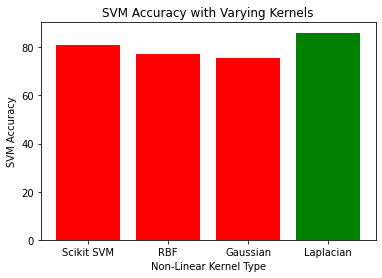

In [9]:
# Used our trained custom non-linear SVM with radial basis function kernel to predict labels from the test set built earlier
prediction_custom_rbf = model_custom_rbf.predict(X_test)

# Used our trained custom non-linear SVM with gaussian kernel to predict labels from the test set built earlier
prediction_custom_gaussian = model_custom_gaussian.predict(X_test)

# Used our trained custom non-linear SVM with laplacian kernel to predict labels from the test set built earlier
prediction_custom_laplacian = model_custom_laplacian.predict(X_test)


# Used the Scikit learn non-linear SVM to predict labels from the same test set built earlier
prediction_scikit = model_scikit.predict(X_test)

correct_custom_rbf = 0
correct_custom_poly = 0
correct_custom_gaussian = 0
correct_custom_laplacian = 0
correct_scikit = 0

# Compare each predictions to the expected labels (ground truth)
for i in range(len(list(y_test))):
  if y_test[i] == prediction_custom_rbf[i]:
    correct_custom_rbf += 1
  if y_test[i] == prediction_custom_gaussian[i]:
    correct_custom_gaussian += 1
  if y_test[i] == prediction_custom_laplacian[i]:
    correct_custom_laplacian += 1
  if y_test[i] == prediction_scikit[i]:
    correct_scikit += 1

# Display classification accuracy for our custom SVMs as well as the Scikit learn one
print('The accuracy from our custom non-linear SVM with radial basis function kernel on the test set is: ' + str('{:.2f}'.format(correct_custom_rbf/len(list(y_test)) * 100)) + '%')
print('The accuracy from our custom non-linear SVM with gaussian kernel on the test set is: ' + str('{:.2f}'.format(correct_custom_gaussian/len(list(y_test)) * 100)) + '%')
print('The accuracy from our custom non-linear SVM with laplacian kernel on the test set is: ' + str('{:.2f}'.format(correct_custom_laplacian/len(list(y_test)) * 100)) + '%\n')
print('The accuracy from the Scikit learn non-linear SVM on the test set is: ' + str('{:.2f}'.format(correct_scikit/len(list(y_test)) * 100)) + '%')

# x-coordinates of left sides of bars  
left = [1, 2, 3, 4] 
  
# heights of bars 
height = [correct_scikit/len(list(y_test)) * 100, 
          correct_custom_rbf/len(list(y_test)) * 100, 
          correct_custom_gaussian/len(list(y_test)) * 100, 
          correct_custom_laplacian/len(list(y_test))* 100]
  
# labels for bars 
tick_label = ['Scikit SVM', 'RBF', 'Gaussian', 'Laplacian'] 

# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, 
        width = 0.8, color = ['red','red','red', 'green']) 


# naming the x-axis 
plt.xlabel('Non-Linear Kernel Type') 
# naming the y-axis 
plt.ylabel('SVM Accuracy') 
# plot title 
plt.title('SVM Accuracy with Varying Kernels') 
  
# function to show the plot 
plt.show() 

Once our SVM model is trained to an optimal accuracy, we then run a sliding window of 3 different heights (smaller in the upper sections of the frame to account for depth) and detect as many people as we can with our SVM for all of the input frames. This is then followed by a duplicate removal of boxes that overlap, while preserving the first box that is detected per each person on the frame. We finish with an estimate of number of people present in each of the 2000 frames, as per submissing requirements for Kaggle.

In [13]:
# n_frames = 2000
n_frames = len(detected_frames)
predictions_per_image = []
svm_boxes_array = []

for count,image_path in enumerate(os.listdir(path_frames)):
    if count >= n_frames:
        break
    #sliding window along one frame
    input_path = os.path.join(path_frames, image_path)
    image = plt.imread(input_path)
    # print(image.shape)
    # plt.figure(figsize=(10, 10))
    # plt.imshow(image)
    # plt.show()
    windows = []
    our_boxes = []
    #sliding window, window size grows as we go down
    for a in range(0,621,20):
        for b in range(0,101,50):
            temp_image = image[b:b+50,a:a+20]
            windows.append(temp_image)
            our_boxes.append([b, a, 50, 20])
    for a in range(0,601,40):
        for b in range(100,301,50):
            temp_image = image[b:b+90,a:a+40]
            windows.append(temp_image)
            our_boxes.append([b, a, 90, 40])
    for a in range(0,591,10):
        for b in range(300,381,80):
            temp_image = image[b:b+100,a:a+50]
            windows.append(temp_image)
            our_boxes.append([b, a, 100, 50])


    # plt.figure(figsize=(5, 5))
    # plt.imshow(windows[-1])
    # plt.show()
    # print('Detected ' + str(len(windows)) + ' windows.')

    np_windows = np.array(windows)
    # print(np_windows.shape)
    # print("getting features")
    test_windows = LBP(images=np_windows, numPoints=24, radius=8)
    # print("making predictions")
    predictions = model_custom_laplacian.predict(np.array(test_windows))
    #put in seperate block so you don't rerun the last block
    pos_windows = []
    our_pos_boxes = []
    for i in range(len(predictions)):
        if (predictions[i] == 1):
            pos_windows.append(np_windows[i])
            our_pos_boxes.append(our_boxes[i])
    np_pos_windows = np.array(pos_windows)

    # print(np_pos_windows.shape)
    # for im in np_pos_windows:
    #   plt.imshow(im)
    #   plt.show()


    delete = []
    for f in range(np_pos_windows.shape[0]):
        delete.append(1)
    for a in range(np_pos_windows.shape[0]):
        if (delete[a] == 1):
            hsv1 = cv2.cvtColor(np_pos_windows[a], cv2.COLOR_BGR2HSV)
            hist1 = cv2.calcHist([hsv1], [0,1], None, [180,256], [0,180,0,256])
            cv2.normalize(hist1, hist1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
            for b in range(np_pos_windows.shape[0]):
                if (delete[b]==1):
                    hsv2 = cv2.cvtColor(np_pos_windows[b], cv2.COLOR_BGR2HSV)
                    hist2 = cv2.calcHist([hsv2], [0,1], None, [180,256], [0,180,0,256])
                    cv2.normalize(hist2, hist2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
                    difference = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
                    #print(difference)
                    if (difference > 0.30 and b != a):
                        delete[b] = 0

    # print(delete)

    im = image.copy()
    people_count = 0
    positive_boxes = []
    for i in range(len(np_pos_windows)):
        if (delete[i] != 0):
            # draw selected boxes in the original image
            cv2.rectangle(im, (round(our_pos_boxes[i][1]),round(our_pos_boxes[i][0])), (round(our_pos_boxes[i][1]+our_pos_boxes[i][3]),round(our_pos_boxes[i][0]+our_pos_boxes[i][2])), (255, 0, 0), 2)
            people_count += 1
            positive_boxes.append(our_pos_boxes[i])

    # only keep as many boxes as yolo frames for IoU computation
    if count < len(detected_frames):
        svm_boxes_array.append(positive_boxes)
                
        
    # plt.figure(figsize=(15, 15))
    # plt.imshow(im)
    # plt.show()
    print("image: " + str(image_path) + " people count: " + str(people_count)) 
    predictions_per_image.append([count+1, people_count])


image: seq_000001.jpg people count: 20
image: seq_000002.jpg people count: 25
image: seq_000003.jpg people count: 22
image: seq_000004.jpg people count: 26
image: seq_000005.jpg people count: 25
image: seq_000006.jpg people count: 21
image: seq_000007.jpg people count: 30
image: seq_000008.jpg people count: 26
image: seq_000009.jpg people count: 23
image: seq_000010.jpg people count: 27
image: seq_000011.jpg people count: 25
image: seq_000012.jpg people count: 22
image: seq_000013.jpg people count: 25
image: seq_000014.jpg people count: 24
image: seq_000015.jpg people count: 20
image: seq_000016.jpg people count: 19
image: seq_000017.jpg people count: 23
image: seq_000018.jpg people count: 24
image: seq_000019.jpg people count: 29
image: seq_000020.jpg people count: 27
image: seq_000021.jpg people count: 27
image: seq_000022.jpg people count: 22
image: seq_000023.jpg people count: 27
image: seq_000024.jpg people count: 21
image: seq_000025.jpg people count: 20
image: seq_000026.jpg peo

IoU Calculation: To calculate the IoU, we first convert the yolo frames and their detected bounding boxes into masks (arrays of 1s and 0s), where 1 represents a pixel inside of a bounding box. We do the same for our SVM people detection. Then we calculate the Intersection over Union of these two masks, which gives us a representation of how accurate our model is compared to ground truth (YOLO).

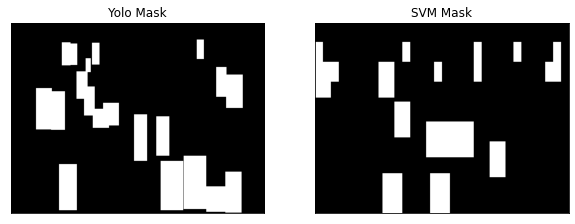

IoU: 0.20618073063805714


In [29]:
# Making masks from bounding boxes for each frame
def make_mask(frame, bounding_boxes, yolo=True):
    # 	a- initialise mask (numpy array) of frame size to 0s.
    mask = np.zeros((frame.shape[0], frame.shape[1]))
    # 	b- for each bounding box in frame, set 
    for box in bounding_boxes:
        x = int(box[0])
        y = int(box[1])
        w = int(box[2])
        h = int(box[3])
        ## TODO: FIX THE BOX X,Y Conventions to avoid the code below
        if yolo:
            mask[y: y+h, x: x+w] = 255
        else: 
            mask[x: x+w, y: y+h] = 255

        
    
    return mask

# Calculating IoU
intersections = []
unions = []

for count, frame in enumerate(detected_frames):
    yolo_mask = make_mask(frame, boxes_positive_patches_array[count])
    svm_mask = make_mask(frame, svm_boxes_array[count], yolo=False)

    # Calculating IoU
    intersections.append(np.logical_and(yolo_mask, svm_mask))
    unions.append(np.logical_or(yolo_mask, svm_mask))

    if count <1:
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(yolo_mask, cmap='gray')
        plt.title('Yolo Mask'), plt.xticks([]), plt.yticks([])
        plt.subplot(1, 2, 2)
        plt.imshow(svm_mask, cmap='gray')
        plt.title('SVM Mask'), plt.xticks([]), plt.yticks([])
        plt.show()

global_IoU = np.sum(intersections) / np.sum(unions)

print("IoU: " + str(global_IoU))


Finally, we export the SVM model prediction into an csv as per Kaggle submission guidelines.

In [ ]:
# field names  
fields = ['id', 'count']  
    
# data rows of csv file  
rows = predictions_per_image

# name of csv file  
filename = "group21_submission.csv"
    
# writing to csv file  
with open(filename, 'w', newline='') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile)  
        
    # writing the fields  
    csvwriter.writerow(fields)  
        
    # writing the data rows  
    csvwriter.writerows(rows)